> 作者：ChZ_CC
> 链接：https://www.jianshu.com/p/f6e489de57f7
> 來源：简书
> 著作权归作者所有。商业转载请联系作者获得授权，非商业转载请注明出处。

窗函数（window function）经常用在频域信号分析中。我其实不咋个懂，大概是从无限长的信号中截一段出来，然后把这一段做延拓变成一个虚拟的无限长的信号。用来截取的函数就叫窗函数，窗函数又分很多种，什么矩形窗、三角窗、高斯窗。

在[scipy.signal](https://link.jianshu.com/?t=https://docs.scipy.org/doc/scipy/reference/signal.html#window-functions)中有各种我不懂的实现窗函数的方法。浏览了一下，头疼的紧。

那在pandas中也有实现窗函数的方法：`rolling()`。我呢就不折腾什么信号处理的东西，用金融数据做个小示例好了。

金融时间序列也是一种时间序列数据，前后次序是固定，多为二维数据。例如要看一只股票的平均移动线，就会用到`rolling()`。

## 先介绍一下这个翻滚函数

`
DataFrame.rolling(window, 
                  min_periods=None, 
                  freq=None, 
                  center=False, 
                  win_type=None, 
                  on=None, 
                  axis=0)
`

- `window`: 移动窗口的大小。值可以是int（整数值）或offset（偏移）。如果是整数值的话，每个窗口是固定的大小，即包含相同数量的观测值。值为offset（偏移时长，eg:`'2s'`）则指定了每个窗口包含的时间段，每个窗口包含的观测值的数量是不一定的。offset必须在index是时间类型数据时才可以使用。

- `min_periods`: 每个窗口最少包含的观测值数量，小于这个值的窗口结果为NA。值可以是int，默认None。offset情况下，默认为1。

- `freq`: 弃用。不用管它。

- `center`: 把窗口的标签设置为居中。布尔型，默认False，居右。

- `win_type`: 窗口的类型。上面介绍的，截取窗的各种函数。字符串类型，默认为None。可用的窗口类型有：

> - boxcar
- triang
- blackman
- hamming
- bartlett
- parzen
- bohman
- blackmanharris
- nuttall
- barthann
- kaiser (needs beta)
- gaussian (needs std)
- general_gaussian (needs power, width)
- slepian (needs width)

- `on`: 可选参数。对于dataframe而言，指定要计算滚动窗口的列。值为列名。

- `axis`: int、字符串，默认为0，即对列进行计算。

使用方法，例：

In [1]:
import numpy as np
import pandas as pd

df = pd.DataFrame({'B': [0, 1, 2, np.nan, 4]})

In [2]:
df.rolling(2).sum()

,B
0,NaN
1,1.0
2,3.0
3,NaN
4,NaN


按tab键可以查看rolling对象可用的方法，如下：

In [3]:
r = df.rolling(2)
r

Rolling [window=2,center=False,axis=0]

`
r.agg             r.cov             r.max             r.ndim
r.aggregate       r.exclusions      r.mean            r.quantile
r.apply           r.is_datetimelike r.median          r.skew
r.corr            r.is_freq_type    r.min             r.std
r.count           r.kurt            r.name            r.sum
`

> 注：`rolling_mean()`这种写法已经淘汰了，现在都是`df.rolling().mean()`、 `df.rolling().std()`这样来写。

## 例：计算苹果收盘价的平均移动线

### 获取数据

从雅虎获取苹果公司2016年1月1日至今的股票数据。

In [4]:
import pandas_datareader as pdr

apple = pdr.get_data_yahoo('AAPL', start='2016-1-1')

In [5]:
apple.head()

,date,high,low,open,close,volume,adjclose
0,2018-03-21,175.089996,171.259995,175.039993,171.270004,36338100.0,171.270004
1,2018-03-20,176.800003,174.940002,175.240005,175.240005,19649400.0,175.240005
2,2018-03-19,177.470001,173.660004,177.320007,175.300003,33446800.0,175.300003
3,2018-03-16,179.119995,177.619995,178.649994,178.020004,39404700.0,178.020004
4,2018-03-15,180.240005,178.070007,178.500000,178.649994,22743800.0,178.649994


### 收盘价的折线图

为了方便观察滚完了之后的效果，我们把数据都画图呈现出来。

In [6]:
apple['close'].plot(figsize=(9, 5), grid=True)

### 平均移动线MA

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11490e048>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1149440f0>], dtype=object)

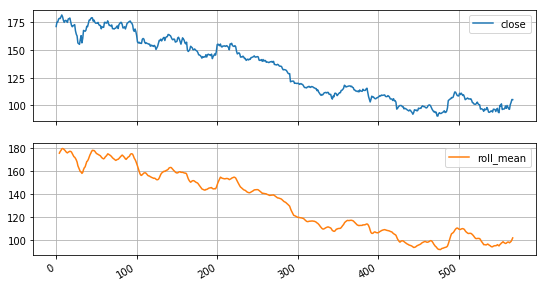

In [7]:
apple['roll_mean'] = apple['close'].rolling(window=5).mean()
apple[['close', 'roll_mean']].plot(subplots=True, figsize=(9, 5), grid=True)

                     收盘价和5日平均移动线

这里窗口大小为5，所以前面四个数据是没有值的。把它们合在一起看看（把subplots改为False）。

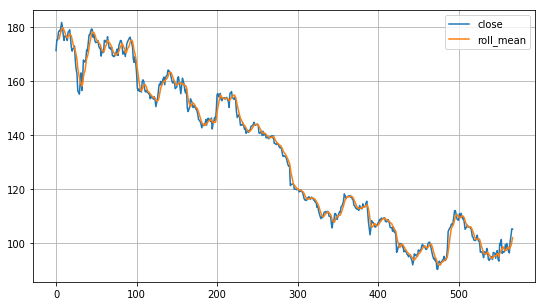

In [8]:
apple['roll_mean'] = apple['close'].rolling(window=5).mean()
apple[['close', 'roll_mean']].plot(subplots=False, figsize=(9, 5), grid=True)

直观上看更平滑了。毕竟取五天做平均了，第一天涨第二天跌的这种一平均波动就小了。如果窗口变大会更平滑。

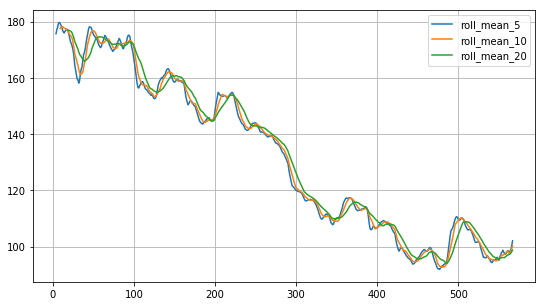

In [9]:
windowsize = [5,10,20]
for i in windowsize:
    apple['roll_mean_'+str(i)] = apple['close'].rolling(i).mean()
apple[['roll_mean_5','roll_mean_10','roll_mean_20']].plot(figsize=(9, 5), grid=True)

### 补充

除了算平均值，还可以计算方差、相关、最大最小值等等，大部分的统计量都可以计算，就看你需要了。

另外如果已有的函数不能满足需要，我们还可以用`lambda`和`apply()`写自己的方法。

例如（直接复制官网的咯）：

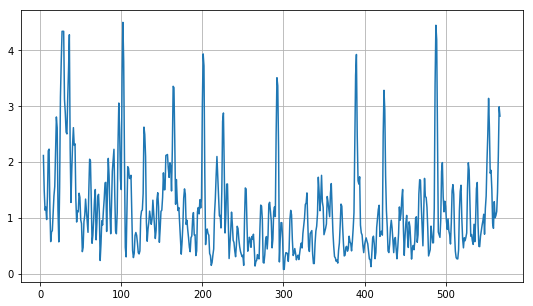

In [10]:
mad = lambda x: np.fabs(x - x.mean()).mean()
apple['close'].rolling(window=5).apply(mad).plot(figsize=(9, 5), grid=True)

这里计算的是平均绝对偏差。

另外，pandas中也有好些金融函数，比如计算指数加权移动平均，就现成的`pandas.ewma()`。待挖掘的东西好多呢。